In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

In [8]:
from multiscale_run import config
conf = config.MsrConfig()

In [9]:
paths = [Path("RESULTS"), Path("RESULTS")]
dfs = [{} for i in enumerate(paths)]
units = [{} for i in enumerate(paths)]
for ii, path in enumerate(paths):
    for file_path in path.rglob('*.h5'):
        if file_path.name != "ndam_spikes.h5":
            with h5py.File(file_path, 'r') as file:
                # Get the data and column names
                data_path = f"/report/{conf.preprocessor.node_sets.neuron_population_name}/data"
                column_path = f"/report/{conf.preprocessor.node_sets.neuron_population_name}/mapping/node_ids"
                time_path = f"/report/{conf.preprocessor.node_sets.neuron_population_name}/mapping/time"

                # Load data and column names into Pandas dataframes
                dfs[ii][file_path.name] = pd.DataFrame(file[data_path][:])
                dfs[ii][file_path.name].columns = file[column_path][:]
                dfs[ii][file_path.name]['t'] = np.arange(*file[time_path][:])

                units[ii][file_path.name] = [file[time_path].attrs["units"], file[data_path].attrs["units"]]


In [22]:
all_gids = [[i for i in list(next(iter(j.values())).columns) if i != 't'] for j in dfs]
all_quantities = [list(i.keys()) for i in dfs]
print("Available GIDs:")
for path, gids, q in zip(paths, all_gids, all_quantities):
    print(f"{path}:\n{gids}\n{q}")

Available GIDs:
RESULTS:
[174, 287, 698, 781, 932, 1003, 1235, 1298, 1406, 1513]
['msr_ndam_Na_conci.h5', 'msr_bf_vol.h5', 'msr_ndam_Ca_conci.h5', 'msr_ndam_atp_conci.h5', 'msr_ndam_K_conci.h5', 'msr_ndam_valid_gid.h5', 'msr_ndam_K_curr.h5', 'msr_ndam_adp_conci.h5', 'msr_ndam_Na_curr.h5', 'msr_bf_Fin.h5', 'msr_steps_KK.h5']
RESULTS:
[174, 287, 698, 781, 932, 1003, 1235, 1298, 1406, 1513]
['msr_ndam_Na_conci.h5', 'msr_bf_vol.h5', 'msr_ndam_Ca_conci.h5', 'msr_ndam_atp_conci.h5', 'msr_ndam_K_conci.h5', 'msr_ndam_valid_gid.h5', 'msr_ndam_K_curr.h5', 'msr_ndam_adp_conci.h5', 'msr_ndam_Na_curr.h5', 'msr_bf_Fin.h5', 'msr_steps_KK.h5']


processing: msr_ndam_Na_conci.h5
processing: msr_bf_vol.h5
processing: msr_ndam_Ca_conci.h5
processing: msr_ndam_atp_conci.h5
processing: msr_ndam_K_conci.h5
processing: msr_ndam_valid_gid.h5
processing: msr_ndam_K_curr.h5
processing: msr_ndam_adp_conci.h5
processing: msr_ndam_Na_curr.h5
processing: msr_bf_Fin.h5
processing: msr_steps_KK.h5


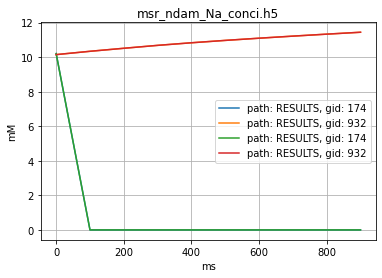

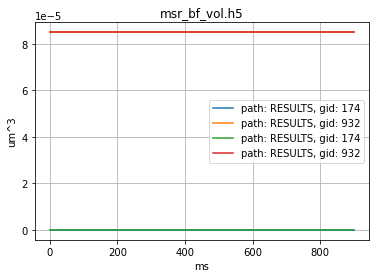

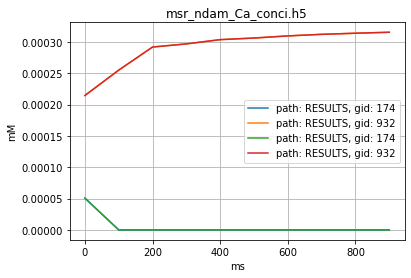

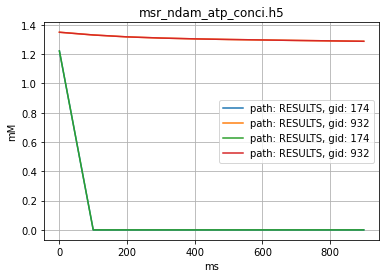

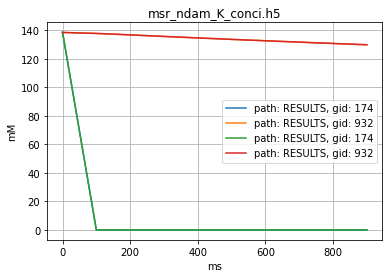

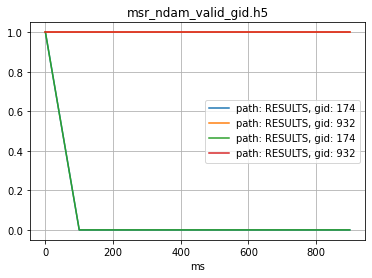

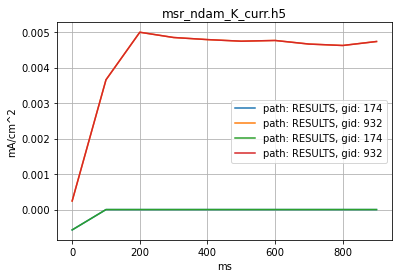

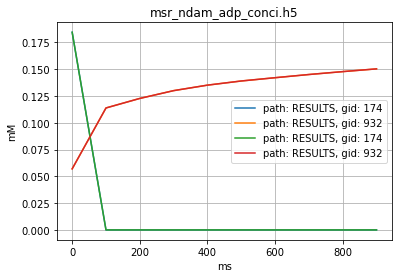

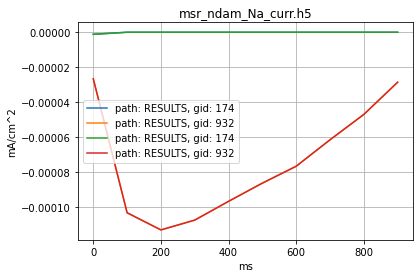

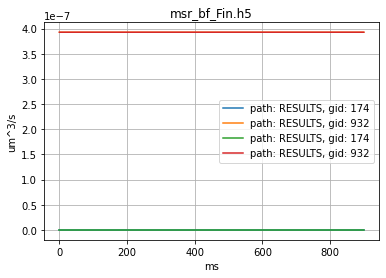

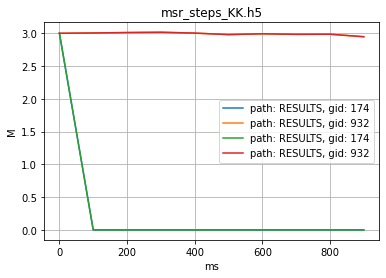

In [27]:
# Get user input for GiD and Quantity
selected_gids = [174, 932]
selected_quantities = all_quantities[0]
img_path = Path('RESULTS/jpg')


img_path.mkdir(parents=True, exist_ok=True)
for quantity in selected_quantities:
    print(f"processing: {quantity}")
    plt.figure()
    for uu in units:
        try:
            u = uu[quantity]
        except KeyError:
            continue
    
    plt.xlabel(u[0])
    plt.ylabel(u[1])
    plt.title(f'{quantity}')
    # Loop through selected gids (traces) for the current quantity
    for ii, path in enumerate(paths):
        for gid in selected_gids:
            try:
                # Get the time trace data for the current quantity and gid
                trace_data = dfs[ii][quantity][gid]
                time_data = dfs[ii][quantity]['t']
            except KeyError:
                continue
        

            # Plot the time trace
            plt.plot(time_data, trace_data, label=f'path: {path}, gid: {gid}')

    # Customize the plot
    plt.legend()
    plt.grid(True)
    
    # Save the figure
    save_path = img_path / f"{quantity}.jpg"
    plt.savefig(save_path, format='jpg')

# Show all the plots
plt.show()